# <span style="color:blue"> Different stages of Alzheimer by CNN and Tranfer Learining </span>
Please refer to the corresponding [kaggle link](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images?select=Alzheimer_s+Dataset) for detals of the data set.

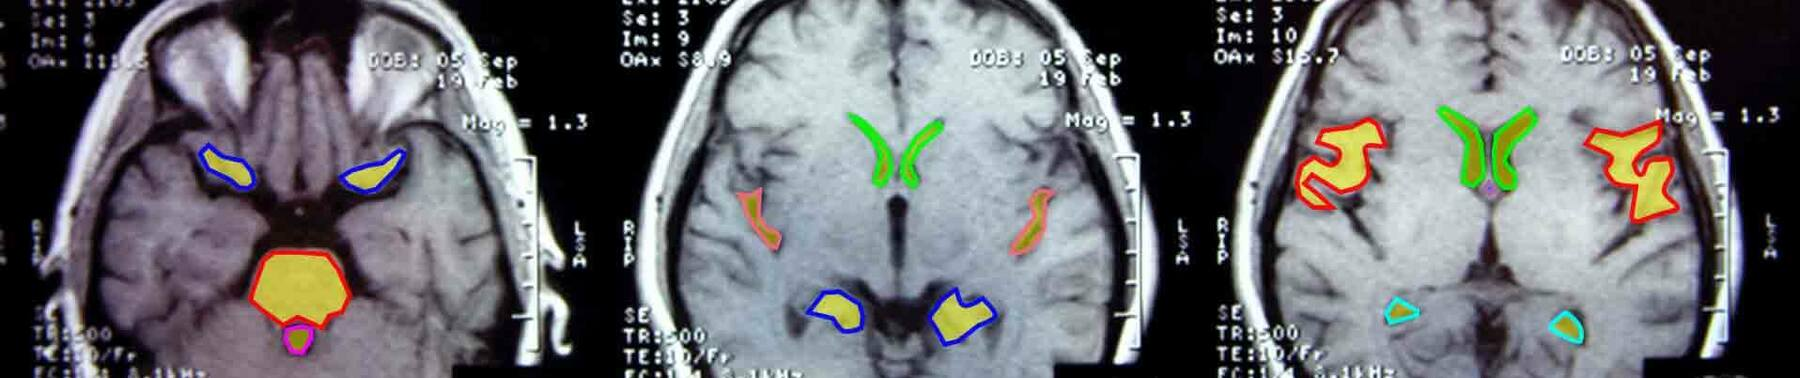

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
tfl = tf.keras.layers

## Load train and test data sets from images
We use [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) from tensorflow.keras.preprocessing to do this task.

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
print("load train data set:")
train_ds = image_dataset_from_directory("Alzheimer_Dataset/train",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)
print("load test data set:")
test_ds = image_dataset_from_directory("Alzheimer_Dataset/test",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)

load train data set:
Found 5121 files belonging to 4 classes.
load test data set:
Found 1279 files belonging to 4 classes.


class names are ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


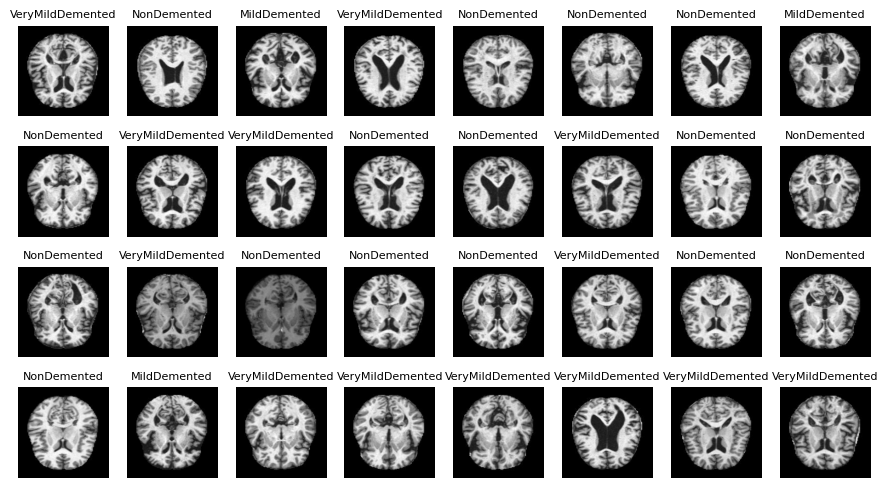

In [3]:
class_names = train_ds.class_names
print(f"class names are {class_names}")
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(11, 6))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

images, labels = next(iter(train_ds))
for i in range(32):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    a.set_title(class_names[labels[i]],fontsize = 8)
    a.set_axis_off()

plt.show()

## Data distribution

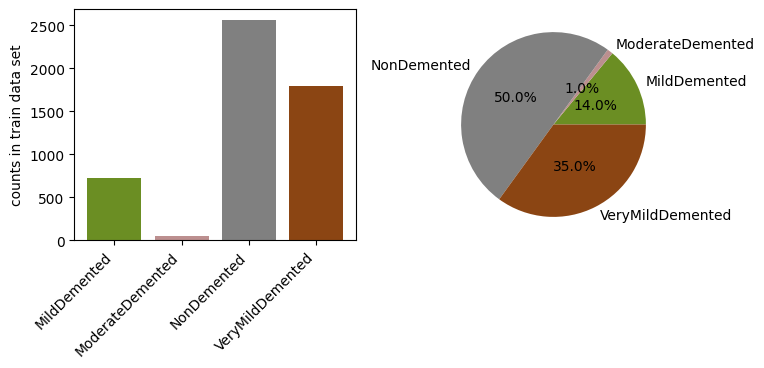

In [4]:
index = np.array([],dtype="int32");
for element in train_ds.as_numpy_iterator():
    index = np.append(index,element[1])
    
unique, counts = np.unique(index, return_counts=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
colors=['olivedrab', 'rosybrown', 'gray', 'saddlebrown']
ax[0].bar(unique,counts,color=colors)
ax[0].set_ylabel(f"counts in train data set")
ax[0].set_xticks(np.arange(len(unique)))
ax[0].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')

ax[1].pie(counts/counts.sum(), labels=[class_names[i] for i in unique],
          autopct='%1.1f%%',pctdistance=0.5, labeldistance=1.1, colors=colors)


plt.show()

# <span style="color:green"> MACHINE LEARNING </span>

## <span style="color:blue"> CNN by Sequential API </span> 

In [5]:
def conv_block(numfilters, padding='same', pool_stride=2):
    model_cb = tf.keras.Sequential([
        tfl.Conv2D(filters=numfilters, kernel_size=3, strides=1, padding=padding, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.MaxPooling2D(pool_size=2)
    ])
    return model_cb

def dense_block(numunits):
    model_db = tf.keras.Sequential([
        tfl.Dense(numunits, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.2)
    ])
    return model_db

IMG_SHAPE = IMG_SIZE + (1,)
model_sequential = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    conv_block(16),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    tfl.Flatten(),
    dense_block(128),
    dense_block(64),
    tfl.Dense(units=4, activation='linear',name='output-layer')
])
model_sequential.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 80, 80, 16)        224       
                                                                 
 sequential_1 (Sequential)   (None, 40, 40, 32)        4768      
                                                                 
 sequential_2 (Sequential)   (None, 20, 20, 64)        18752     
                                                                 
 sequential_3 (Sequential)   (None, 10, 10, 128)       74368     
                                                                 
 sequential_4 (Sequential)   (None, 5, 5, 256)         296192    
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 sequential_5 (Sequential)   (None, 128)              

In [6]:
model_sequential.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [7]:
def scheduler(epoch, lr):
    return lr*(0.1**(0.05*epoch))

my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint("alzheimer_model_sequential.h5", monitor='val_accuracy', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

In [8]:
history_sequential = model_sequential.fit(train_ds, validation_data=test_ds,
                                          callbacks=my_callbacks, epochs=30,
                                          batch_size=32, verbose=0)
print("Finished!")

Finished!


In [9]:
alzheimer_model_sequential = tf.keras.models.load_model('alzheimer_model_sequential.h5')
alzheimer_model_sequential.trainable = False
print(f"Train accuracy = {alzheimer_model_sequential.evaluate(train_ds,verbose=0)[1]*100:.2f}%")
print(f"Valid accuracy = {alzheimer_model_sequential.evaluate(test_ds,verbose=0)[1]*100:.2f}%")

Train accuracy = 100.00%
Valid accuracy = 74.35%


**Note:** We could do better probably! But it is good enough for this CNN. We will use Tranfer Learning to get better results.

## <span style="color:blue"> Tranfer Learning </span> 

### Data preparation
- Map the grayscale data to RGB
- Transoform the target label to one-hot encoding (needed for the AUC() metric)

In [10]:
# Convert to rgb
train_ds_rgb = train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
test_ds_rgb = test_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
IMG_SHAPE = IMG_SIZE + (3,)

# One-hot encoded
train_ds_OHE = train_ds_rgb.map(lambda x, y: (x, tf.one_hot(y, depth=4)))
test_ds_OHE = test_ds_rgb.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

In [11]:
# prefetch the training data
# see the corresponding documentation link at https://www.tensorflow.org/guide/data_performance for detail.
train_ds_rgb = train_ds_rgb.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## <span style="color:green"> InceptionV3 </span>

### <span style="color:olive"> Step 1: Add a new classifier </span>
The function below gets a trained_model (e.g., MobileNetV2, ResNet50), freezes all layers, and adds a new classifier.

In [131]:
def my_model(trained_model,preprocess):
    base_model = trained_model(input_shape=IMG_SHAPE,
                               include_top=False,
                               weights='imagenet')
    
    base_model.trainable = False 
    inputs = tf.keras.Input(shape=IMG_SHAPE) 
    x = preprocess(inputs) 
    x = base_model(x) 
    
    # new layers
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(rate=0.2)(x)
    outputs = tfl.Dense(units=4, activation='linear', name='classification_layer')(x) 
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [132]:
import tensorflow.keras.applications.inception_v3 as inception
model = my_model(inception.InceptionV3, inception.preprocess_input)

**Note:** One could simply use another big pretrained model such as MobileNetV2:
- import tensorflow.keras.applications.mobilenet_v2 as mobilenet
- model = my_model(mobilenet.MobileNetV2, mobilenet.preprocess_input)

In [133]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [134]:
base_learning_rate = 0.001
my_metric = tf.keras.metrics.AUC(name='auc')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[my_metric])

**Note:** We are using tf.keras.metrics.AUC() instead of tf.keras.metrics.Accuracy() which we used previsously.

In [135]:
class PrinterCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"EPOCH: {epoch:2d}, Train Auc: {logs['auc']:.4f}, Val Auc: {logs['val_auc']:.4f}")

    def on_epoch_begin(self, epoch, logs=None):
        print('-'*50)
        print(f"STARTING EPOCH: {epoch:2d}")


In [136]:
initial_epochs = 7
model.fit(train_ds_OHE, validation_data=test_ds_OHE,
          callbacks=[PrinterCallback()], epochs=initial_epochs,
          batch_size=32, verbose=0)

--------------------------------------------------
STARTING EPOCH:  0
EPOCH:  0, Train Auc: 0.7276, Val Auc: 0.7389
--------------------------------------------------
STARTING EPOCH:  1
EPOCH:  1, Train Auc: 0.7598, Val Auc: 0.7492
--------------------------------------------------
STARTING EPOCH:  2
EPOCH:  2, Train Auc: 0.7701, Val Auc: 0.7697
--------------------------------------------------
STARTING EPOCH:  3
EPOCH:  3, Train Auc: 0.7815, Val Auc: 0.7536
--------------------------------------------------
STARTING EPOCH:  4
EPOCH:  4, Train Auc: 0.7907, Val Auc: 0.7743
--------------------------------------------------
STARTING EPOCH:  5
EPOCH:  5, Train Auc: 0.7969, Val Auc: 0.7681
--------------------------------------------------
STARTING EPOCH:  6
EPOCH:  6, Train Auc: 0.8028, Val Auc: 0.7442


### <span style="color:olive"> Step 2: Fine-tune by training the deep layers </span>

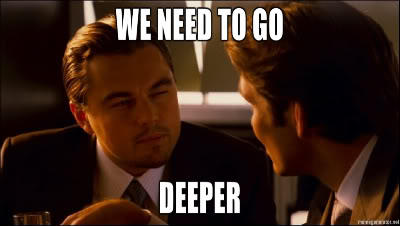

In [137]:
index_base_model = 3# layer number 3 is the base_model
model.layers[index_base_model].trainable = True

num_finetuned_layers = 30
num_layers = len(model.layers[index_base_model].layers)
for layer in model.layers[index_base_model].layers[:num_layers-num_finetuned_layers]:
    layer.trainable = False

model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [138]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01*base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[my_metric])
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("alzheimer_model_inception.h5", monitor='val_auc', save_best_only=True),
    PrinterCallback()
]

In [139]:
fine_tune_epochs = 23
total_epochs = initial_epochs + fine_tune_epochs
history = model.fit(train_ds_OHE, validation_data=test_ds_OHE,
                    callbacks=my_callbacks, epochs=total_epochs, initial_epoch=initial_epochs,
                    batch_size=32, verbose=0)
print("Finished!")

--------------------------------------------------
STARTING EPOCH:  7
EPOCH:  7, Train Auc: 0.7682, Val Auc: 0.7573
--------------------------------------------------
STARTING EPOCH:  8
EPOCH:  8, Train Auc: 0.8121, Val Auc: 0.7464
--------------------------------------------------
STARTING EPOCH:  9
EPOCH:  9, Train Auc: 0.8372, Val Auc: 0.7505
--------------------------------------------------
STARTING EPOCH: 10
EPOCH: 10, Train Auc: 0.8624, Val Auc: 0.7519
--------------------------------------------------
STARTING EPOCH: 11
EPOCH: 11, Train Auc: 0.8791, Val Auc: 0.7561
--------------------------------------------------
STARTING EPOCH: 12
EPOCH: 12, Train Auc: 0.8977, Val Auc: 0.7586
--------------------------------------------------
STARTING EPOCH: 13
EPOCH: 13, Train Auc: 0.9180, Val Auc: 0.7660
--------------------------------------------------
STARTING EPOCH: 14
EPOCH: 14, Train Auc: 0.9293, Val Auc: 0.7666
--------------------------------------------------
STARTING EPOCH: 15
EP

# <span style="color:green"> TESTING & REMARKS </span>

## Predictions for the validation data set

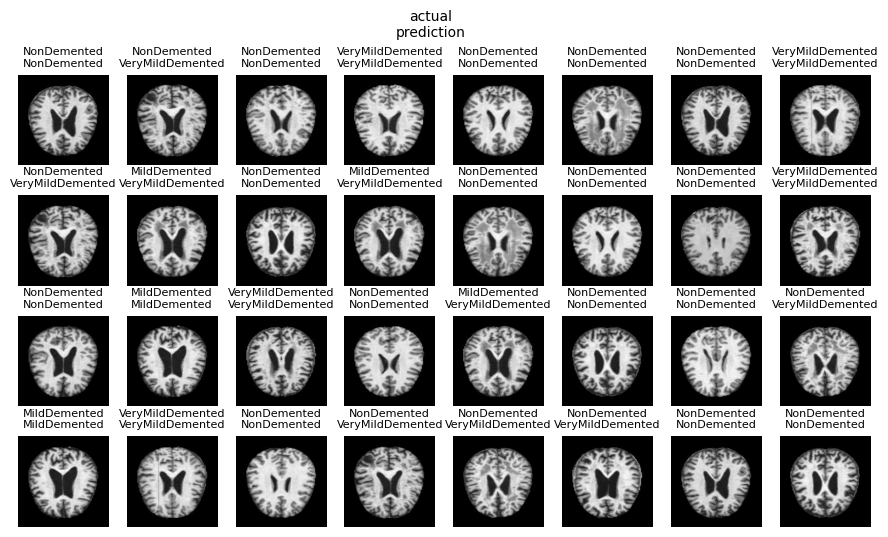

In [208]:
alzheimer_model_inception = model #tf.keras.models.load_model('alzheimer_model_inception.h5')
alzheimer_model_inception.trainable = False
image_batch, label_batch = next(iter(test_ds_OHE))
preds_batch = alzheimer_model_inception(image_batch).numpy()
yhat_batch = np.argmax(preds_batch,axis=1)
m = image_batch.shape[0]
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(11, 6))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

from termcolor import colored
for a in ax.flat:
    random_index = np.random.randint(m)
    a.imshow(image_batch[random_index].numpy().astype("uint8"))
    print_data = class_names[np.argmax(label_batch[random_index])]
    print_pred = class_names[yhat_batch[random_index]]
    title = f"{print_data}\n{print_pred}"
    a.set_title(title,fontsize = 8)
    a.set_axis_off()

fig.suptitle('actual\nprediction',fontsize=10)
plt.show()

## Concluding remarks

- Several other pretrained models such as MobileNetV2 and ResNet50 have been tested as well. InceptionV3 appears to give the best result for the validation data set (less overfitting).
- From the representative cases above, one can notice that most of the misclassified cases are those labeled as "VeryMildDemanted" by the model.
- We could potentially run the fine-tuning part for more epochs to get better results.